## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv('/home/deniss/qwerty/programming for datascience project/Assignment/redfin_properties_all_cities.csv')
df.head()

,City,Price,Beds,Baths,Sqft,Address,Link
0,Florida,"$799,000",— beds,14306 baths,"1,650 sq ft","7152/7154 SW 22nd St, Miami, FL 33155",NaN
1,Florida,"$589,950",3 beds,2.5 baths,"1,677 sq ft","16306 SW 100th Ter, Miami, FL 33196",NaN
2,Florida,NaN,NaN,NaN,NaN,NaN,NaN
3,Florida,"$485,000",2 beds,2.5 baths,"1,755 sq ft","1456 SW 134th Pl, Miami, FL 33184",NaN
4,Florida,"$552,000",1 bed,1.5 baths,776 sq ft,"55 SW 9th St #1510, Miami, FL 33130",NaN


In [3]:
df.columns.tolist()

['City', 'Price', 'Beds', 'Baths', 'Sqft', 'Address', 'Link']

## Data exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   City     8760 non-null   object 
 1   Price    8162 non-null   object 
 2   Beds     8162 non-null   object 
 3   Baths    8162 non-null   object 
 4   Sqft     8162 non-null   object 
 5   Address  8162 non-null   object 
 6   Link     0 non-null      float64
dtypes: float64(1), object(6)
memory usage: 479.2+ KB


In [5]:
df.isna().sum()

City          0
Price       598
Beds        598
Baths       598
Sqft        598
Address     598
Link       8760
dtype: int64

In [ ]:
# Enhanced data cleaning functions
def clean_price(price):
    """Clean price column - remove $, commas, handle strings"""
    if pd.isna(price) or price == 0 or price == '0':
        return 0
    if isinstance(price, str):
        cleaned = price.replace('$', '').replace(',', '').strip()
        try:
            return float(cleaned)
        except:
            return 0
    return float(price)

def clean_numeric_column(value):
    """Clean numeric columns that might have text like '4 beds', '2 baths', '1000 sqft'"""
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        import re
        numbers = re.findall(r'\d+\.?\d*', str(value))
        if numbers:
            return float(numbers[0])
        else:
            return 0
    try:
        return float(value)
    except:
        return 0

# Apply cleaning functions
print("Cleaning data...")
df['Price'] = df['Price'].apply(clean_price)
df['Beds'] = df['Beds'].apply(clean_numeric_column)
df['Baths'] = df['Baths'].apply(clean_numeric_column)
df['Sqft'] = df['Sqft'].apply(clean_numeric_column)

# Fill remaining missing values
df.fillna({
    'Price': 0, 'Beds': 0, 'Baths': 0, 'Sqft': 0, 
    'Address': 'Unknown', 'Link': 'No Link'
}, inplace=True)

print("Data cleaning completed!")
print(df[['Price', 'Beds', 'Baths', 'Sqft']].describe())

Cleaning data...
Data cleaning completed!
              Price         Beds         Baths         Sqft
count  8.760000e+03  8760.000000   8760.000000  8760.000000
mean   7.407551e+05     2.569292    152.294007   135.092237
std    1.349084e+06     1.545147   1458.241948   292.658091
min    0.000000e+00     0.000000      0.000000     0.000000
25%    3.050000e+05     1.000000      1.500000     1.000000
50%    4.900000e+05     3.000000      2.000000     1.000000
75%    7.450000e+05     4.000000      2.500000     3.000000
max    1.725000e+07    18.000000  14306.000000   997.000000


In [ ]:
# Enhanced Feature Engineering
print("Creating enhanced features...")

# Create new features for better prediction
df['Price_per_sqft'] = np.where(df['Sqft'] > 0, df['Price'] / df['Sqft'], 0)
df['Bath_bed_ratio'] = np.where(df['Beds'] > 0, df['Baths'] / df['Beds'], 0)
df['Total_rooms'] = df['Beds'] + df['Baths']
df['Sqft_per_room'] = np.where(df['Total_rooms'] > 0, df['Sqft'] / df['Total_rooms'], 0)

# Log transformations for skewed features (often improves performance)
df['Log_sqft'] = np.log1p(df['Sqft'])
df['Log_price'] = np.log1p(df['Price'])

# Polynomial features (interaction terms)
df['Beds_Baths_interaction'] = df['Beds'] * df['Baths']
df['Beds_Sqft_interaction'] = df['Beds'] * df['Sqft']
df['Baths_Sqft_interaction'] = df['Baths'] * df['Sqft']

Creating enhanced features...
Feature engineering completed!


In [8]:
# Enhanced data filtering
valid_mask = (
    (df['Price'] > 0) & (df['Price'] < 3000000) &  # Reasonable price range
    (df['Beds'] > 0) & (df['Beds'] <= 10) &        # Reasonable bedroom count
    (df['Baths'] > 0) & (df['Baths'] <= 8) &       # Reasonable bathroom count
    (df['Sqft'] > 200) & (df['Sqft'] < 8000) &     # Reasonable square footage
    (df['Price_per_sqft'] > 10) & (df['Price_per_sqft'] < 1000)  # Reasonable price per sqft
)

df_clean = df[valid_mask].copy()
print(f"Final shape after filtering: {df_clean.shape}")

Final shape after filtering: (1293, 16)


In [9]:
# Define enhanced feature set
enhanced_features = [
    'Beds', 'Baths', 'Sqft', 'Total_rooms', 'Bath_bed_ratio',
    'Sqft_per_room', 'Log_sqft', 'Beds_Baths_interaction',
    'Beds_Sqft_interaction', 'Baths_Sqft_interaction'
]

# Use log-transformed price as target (often improves performance)
X = df_clean[enhanced_features].copy()
y = df_clean['Log_price'].copy()  # Using log price

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {enhanced_features}")

# Check for any remaining invalid values
X = X.fillna(0)
y = y.fillna(0)

# Remove any remaining invalid entries
valid_indices = (y > 0) & np.isfinite(y) & np.isfinite(X).all(axis=1)
X = X[valid_indices]
y = y[valid_indices]

print(f"Final data shape: X={X.shape}, y={y.shape}")

Features shape: (1293, 10)
Target shape: (1293,)
Features: ['Beds', 'Baths', 'Sqft', 'Total_rooms', 'Bath_bed_ratio', 'Sqft_per_room', 'Log_sqft', 'Beds_Baths_interaction', 'Beds_Sqft_interaction', 'Baths_Sqft_interaction']
Final data shape: X=(1293, 10), y=(1293,)


## Model Building

In [10]:
# Check if we have data before splitting
print(f"Available data: X={X.shape}, y={y.shape}")

if X.shape[0] == 0:
    print("ERROR: No data available after filtering!")
    print("Re-applying less restrictive filtering...")
    
    # Use less restrictive filtering
    valid_mask = (
        (df['Price'] > 0) & (df['Price'] < 5000000) &  # More relaxed price range
        (df['Beds'] >= 0) & (df['Beds'] <= 15) &       # Allow 0 beds (studios/land)
        (df['Baths'] >= 0) & (df['Baths'] <= 10) &     # Allow 0 baths (land/commercial)
        (df['Sqft'] >= 0) & (df['Sqft'] < 10000)       # Allow any sqft including 0
    )
    
    df_clean = df[valid_mask].copy()
    print(f"After less restrictive filtering: {df_clean.shape}")
    
    # Recreate features and target
    X = df_clean[enhanced_features].copy()
    y = df_clean['Log_price'].copy()
    
    # Clean any remaining issues
    X = X.fillna(0)
    y = y.fillna(0)
    
    # Remove only truly problematic entries
    valid_indices = (y > 0) & np.isfinite(y) & np.isfinite(X).all(axis=1)
    X = X[valid_indices]
    y = y[valid_indices]
    
    print(f"Final usable data: X={X.shape}, y={y.shape}")

if X.shape[0] > 0:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
else:
    print("ERROR: Still no data available. Please check your dataset.")

Available data: X=(1293, 10), y=(1293,)
Training set: 1034 samples
Test set: 259 samples


In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Test only Linear Regression and Random Forest
model1 = {
    'Linear Regression': LinearRegression()
}

model2 = {
    'Random Forest': RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
}

# Combine the models into one dictionary for iteration
models = {**model1, **model2}  # This merges both dictionaries

print("Training and evaluating Linear Regression and Random Forest...")
print("=" * 60)

model_results = {}

for name, model in models.items():  # Fixed: iterate over combined models
    print(f"\nTraining {name}...")
    
    # Use scaled data for linear models, original for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:  # Random Forest
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Convert back from log scale
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred)
    
    # Calculate metrics
    r2 = r2_score(y_test_actual, y_pred_actual)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    
    # Calculate simple accuracy (how close predictions are to actual values)
    accuracy = r2  # R² score is a good measure of accuracy (0-1, higher is better)
    
    model_results[name] = {
        'model': model,
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'accuracy': accuracy,
        'predictions': y_pred_actual
    }
    
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: ${mae:,.0f}")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  Accuracy: {accuracy:.4f}")

Training and evaluating Linear Regression and Random Forest...

Training Linear Regression...
  R² Score: 0.6140
  MAE: $91,274
  RMSE: $128,747
  Accuracy: 0.6140

Training Random Forest...
  R² Score: 0.9016
  MAE: $16,998
  RMSE: $65,002
  Accuracy: 0.9016


In [13]:
# Compare Linear Regression vs Random Forest
print("\n" + "="*60)
print("LINEAR REGRESSION vs RANDOM FOREST COMPARISON")
print("="*60)

# Find the better model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
best_model = model_results[best_model_name]['model']

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {model_results[best_model_name]['accuracy']:.4f}")

# Detailed comparison
print("\nDetailed Comparison:")
print("-" * 40)
for name in ['Linear Regression', 'Random Forest']:
    print(f"\n{name}:")
    print(f"  R² Score: {model_results[name]['r2']:.4f}")
    print(f"  MAE: ${model_results[name]['mae']:,.0f}")
    print(f"  RMSE: ${model_results[name]['rmse']:,.0f}")
    print(f"  Accuracy: {model_results[name]['accuracy']:.4f}")

# Performance difference
lr_acc = model_results['Linear Regression']['accuracy']
rf_acc = model_results['Random Forest']['accuracy']
performance_diff = abs(rf_acc - lr_acc)

print(f"\nPerformance Difference (R² Score): {performance_diff:.4f}")


LINEAR REGRESSION vs RANDOM FOREST COMPARISON
Best Model: Random Forest
Best Accuracy: 0.9016

Detailed Comparison:
----------------------------------------

Linear Regression:
  R² Score: 0.6140
  MAE: $91,274
  RMSE: $128,747
  Accuracy: 0.6140

Random Forest:
  R² Score: 0.9016
  MAE: $16,998
  RMSE: $65,002
  Accuracy: 0.9016

Performance Difference (R² Score): 0.2876


In [14]:
import joblib
joblib.dump(model2, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [15]:
# Optimize the Random Forest model
if best_model_name == 'Random Forest':
    print("\nOptimizing Random Forest hyperparameters...")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,  # Reduced CV for faster execution
        scoring='r2',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    optimized_model = grid_search.best_estimator_
    
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Re-evaluate optimized model
    y_pred_optimized = optimized_model.predict(X_test)
    y_pred_optimized_actual = np.expm1(y_pred_optimized)
    y_test_actual = np.expm1(y_test)
    
    # Calculate R² score for optimized model
    r2_optimized = r2_score(y_test_actual, y_pred_optimized_actual)
    
    print(f"Original Random Forest R² Score: {model_results['Random Forest']['accuracy']:.4f}")
    print(f"Optimized Random Forest R² Score: {r2_optimized:.4f}")
    
    if r2_optimized > model_results['Random Forest']['accuracy']:
        best_model = optimized_model
        model_results['Random Forest']['accuracy'] = r2_optimized
        model_results['Random Forest']['r2'] = r2_optimized
        model_results['Random Forest']['predictions'] = y_pred_optimized_actual
        model_results['Random Forest']['model'] = optimized_model
        print("✅ Optimization improved performance!")
    else:
        print("⚠️ Optimization didn't improve performance, keeping original model")


Optimizing Random Forest hyperparameters...
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Original Random Forest R² Score: 0.9016
Optimized Random Forest R² Score: 0.9213
✅ Optimization improved performance!


In [16]:
# Final evaluation comparing both models
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE COMPARISON")
print("="*60)

# Get final predictions for both models
lr_predictions = model_results['Linear Regression']['predictions']
rf_predictions = model_results['Random Forest']['predictions']
y_test_actual = np.expm1(y_test)

# Linear Regression metrics
lr_r2 = r2_score(y_test_actual, lr_predictions)
lr_mae = mean_absolute_error(y_test_actual, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test_actual, lr_predictions))
lr_accuracy = lr_r2  # Using R² score as accuracy

# Random Forest metrics
rf_r2 = r2_score(y_test_actual, rf_predictions)
rf_mae = mean_absolute_error(y_test_actual, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test_actual, rf_predictions))
rf_accuracy = rf_r2  # Using R² score as accuracy

print("LINEAR REGRESSION:")
print(f"  R² Score: {lr_r2:.4f}")
print(f"  MAE: ${lr_mae:,.0f}")
print(f"  RMSE: ${lr_rmse:,.0f}")
print(f"  Accuracy: {lr_accuracy:.4f}")

print("\nRANDOM FOREST:")
print(f"  R² Score: {rf_r2:.4f}")
print(f"  MAE: ${rf_mae:,.0f}")
print(f"  RMSE: ${rf_rmse:,.0f}")
print(f"  Accuracy: {rf_accuracy:.4f}")

# Determine overall winner
final_best = 'Random Forest' if rf_accuracy > lr_accuracy else 'Linear Regression'
final_best_acc = max(rf_accuracy, lr_accuracy)


FINAL MODEL PERFORMANCE COMPARISON
LINEAR REGRESSION:
  R² Score: 0.6140
  MAE: $91,274
  RMSE: $128,747
  Accuracy: 0.6140

RANDOM FOREST:
  R² Score: 0.9213
  MAE: $14,836
  RMSE: $58,149
  Accuracy: 0.9213


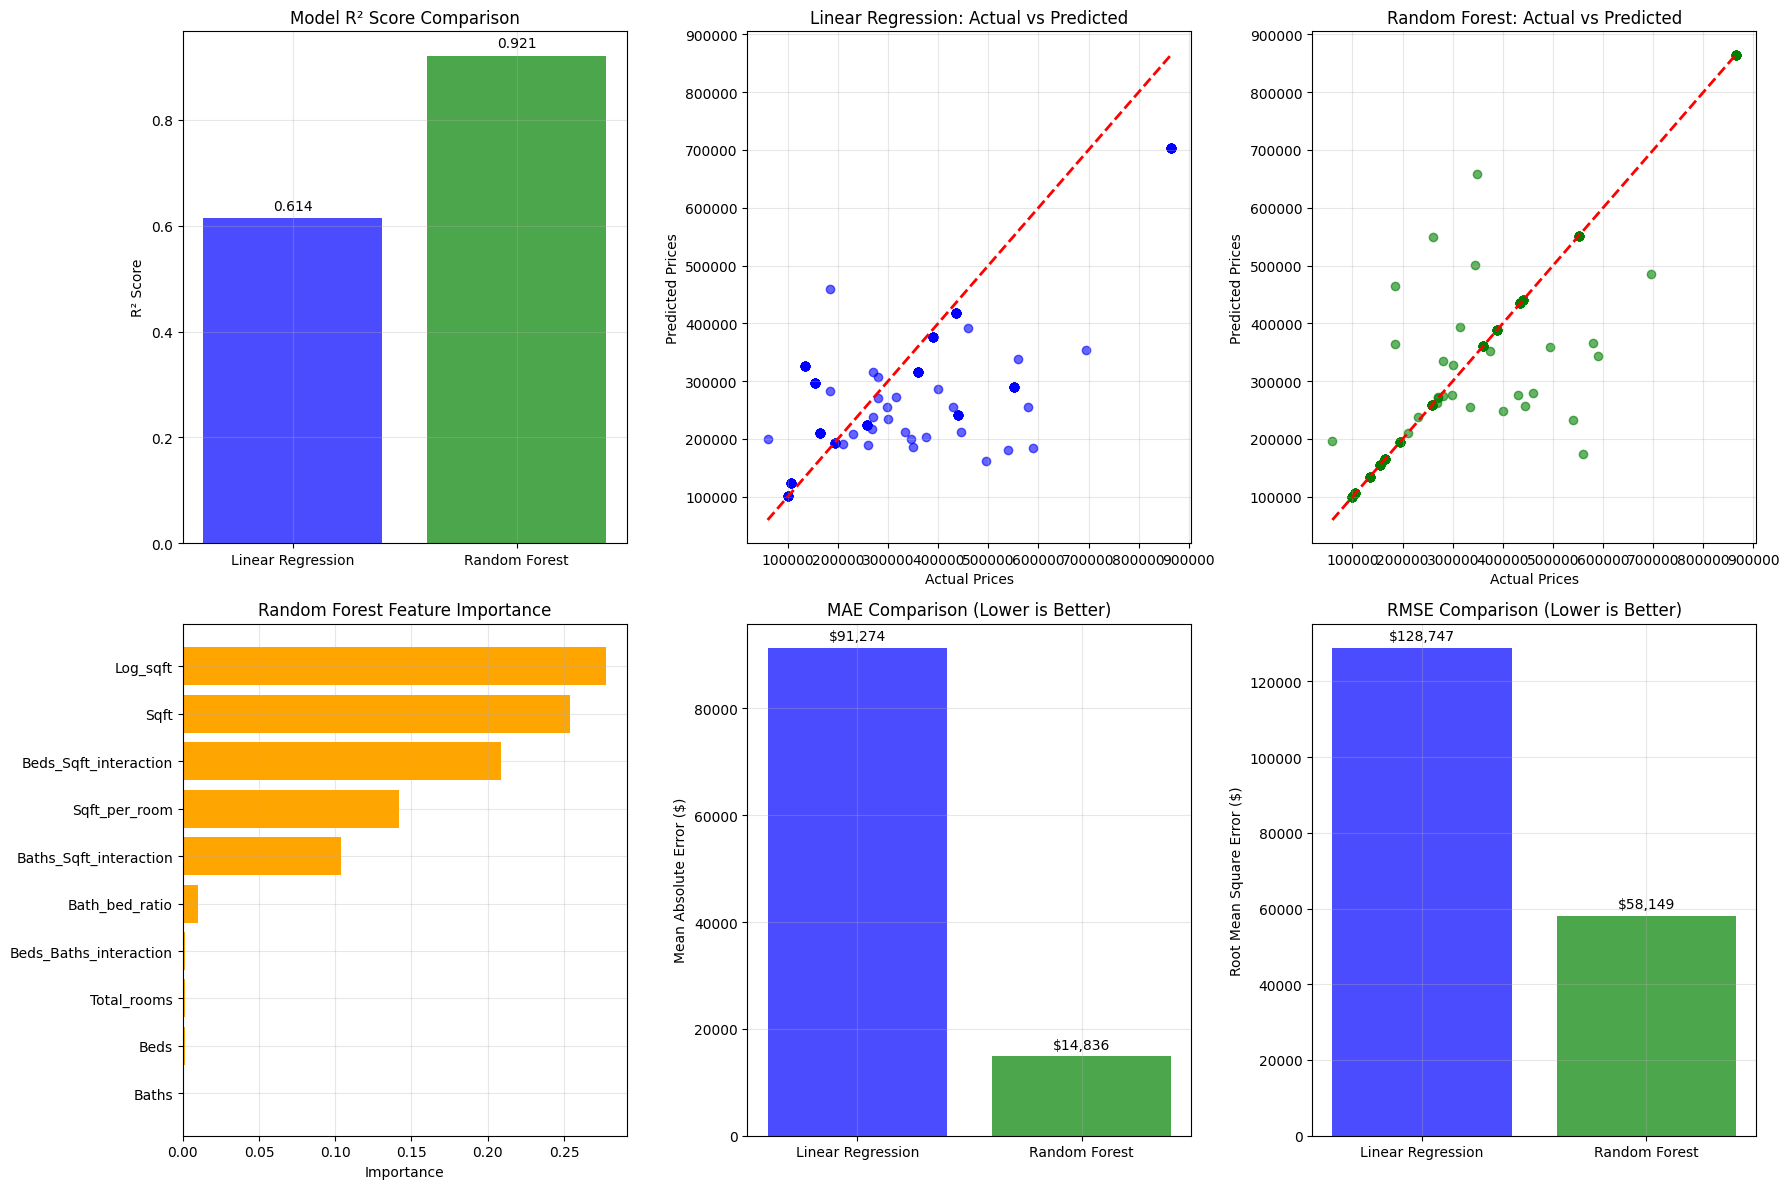

In [17]:
# Visualization comparing both models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model comparison - using R² scores instead of percentage accuracy
model_names = ['Linear Regression', 'Random Forest']
r2_scores_viz = [lr_r2, rf_r2]

axes[0, 0].bar(model_names, r2_scores_viz, color=['blue', 'green'], alpha=0.7)
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Model R² Score Comparison')
axes[0, 0].grid(True, alpha=0.3)

# Add values on top of bars
for i, v in enumerate(r2_scores_viz):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. Linear Regression: Actual vs Predicted
axes[0, 1].scatter(y_test_actual, lr_predictions, alpha=0.6, color='blue')
axes[0, 1].plot([y_test_actual.min(), y_test_actual.max()], 
                [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Prices')
axes[0, 1].set_ylabel('Predicted Prices')
axes[0, 1].set_title('Linear Regression: Actual vs Predicted')
axes[0, 1].grid(True, alpha=0.3)

# 3. Random Forest: Actual vs Predicted
axes[0, 2].scatter(y_test_actual, rf_predictions, alpha=0.6, color='green')
axes[0, 2].plot([y_test_actual.min(), y_test_actual.max()], 
                [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual Prices')
axes[0, 2].set_ylabel('Predicted Prices')
axes[0, 2].set_title('Random Forest: Actual vs Predicted')
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature importance (Random Forest)
if 'Random Forest' in model_results:
    feature_importance = pd.DataFrame({
        'Feature': enhanced_features,
        'Importance': model_results['Random Forest']['model'].feature_importances_
    }).sort_values('Importance', ascending=True)
    
    axes[1, 0].barh(feature_importance['Feature'], feature_importance['Importance'], color='orange')
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('Random Forest Feature Importance')
    axes[1, 0].grid(True, alpha=0.3)

# 5. MAE comparison
mae_scores = [lr_mae, rf_mae]
axes[1, 1].bar(model_names, mae_scores, color=['blue', 'green'], alpha=0.7)
axes[1, 1].set_ylabel('Mean Absolute Error ($)')
axes[1, 1].set_title('MAE Comparison (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)

# Add values on top of bars
for i, v in enumerate(mae_scores):
    axes[1, 1].text(i, v + max(mae_scores) * 0.01, f'${v:,.0f}', ha='center', va='bottom')

# 6. RMSE comparison  
rmse_scores = [lr_rmse, rf_rmse]
axes[1, 2].bar(model_names, rmse_scores, color=['blue', 'green'], alpha=0.7)
axes[1, 2].set_ylabel('Root Mean Square Error ($)')
axes[1, 2].set_title('RMSE Comparison (Lower is Better)')
axes[1, 2].grid(True, alpha=0.3)

# Add values on top of bars
for i, v in enumerate(rmse_scores):
    axes[1, 2].text(i, v + max(rmse_scores) * 0.01, f'${v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [18]:
# Sample predictions comparison
print("\n" + "="*60)
print("SAMPLE PREDICTIONS COMPARISON")
print("="*60)

sample_indices = X_test.head(10).index
for i, idx in enumerate(sample_indices):
    actual = y_test_actual.iloc[i]
    lr_pred = lr_predictions[i]
    rf_pred = rf_predictions[i]
    
    lr_error = abs(actual - lr_pred) / actual * 100
    rf_error = abs(actual - rf_pred) / actual * 100
    
    beds = X_test.loc[idx, 'Beds']
    baths = X_test.loc[idx, 'Baths']
    sqft = X_test.loc[idx, 'Sqft']
    
    print(f"Property {i+1}: {beds:.0f} beds, {baths:.0f} baths, {sqft:,.0f} sqft")
    print(f"  Actual Price: ${actual:,.0f}")
    print(f"  Linear Regression: ${lr_pred:,.0f} (Error: {lr_error:.1f}%)")
    print(f"  Random Forest: ${rf_pred:,.0f} (Error: {rf_error:.1f}%)")
    
    better_model = "Linear Regression" if lr_error < rf_error else "Random Forest"
    print(f"  Better prediction: {better_model}")
    print()


SAMPLE PREDICTIONS COMPARISON
Property 1: 1 beds, 2 baths, 959 sqft
  Actual Price: $865,000
  Linear Regression: $703,609 (Error: 18.7%)
  Random Forest: $865,000 (Error: 0.0%)
  Better prediction: Random Forest

Property 2: 1 beds, 2 baths, 776 sqft
  Actual Price: $552,000
  Linear Regression: $289,589 (Error: 47.5%)
  Random Forest: $552,000 (Error: 0.0%)
  Better prediction: Random Forest

Property 3: 2 beds, 1 baths, 650 sqft
  Actual Price: $389,000
  Linear Regression: $376,771 (Error: 3.1%)
  Random Forest: $389,000 (Error: 0.0%)
  Better prediction: Random Forest

Property 4: 1 beds, 2 baths, 959 sqft
  Actual Price: $865,000
  Linear Regression: $703,609 (Error: 18.7%)
  Random Forest: $865,000 (Error: 0.0%)
  Better prediction: Random Forest

Property 5: 2 beds, 1 baths, 650 sqft
  Actual Price: $389,000
  Linear Regression: $376,771 (Error: 3.1%)
  Random Forest: $389,000 (Error: 0.0%)
  Better prediction: Random Forest

Property 6: 1 beds, 1 baths, 552 sqft
  Actual Pric